In [6]:
!rm -rf /Users/sabrinadefigueiredosouto/Documents/241165

In [1]:
!git clone https://github.com/ModelDBRepository/241165

Cloning into '241165'...
remote: Enumerating objects: 477, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 477 (delta 27), reused 6 (delta 2), pack-reused 442 (from 1)
Receiving objects: 100% (477/477), 9.51 MiB | 1.16 MiB/s, done.
Resolving deltas: 100% (264/264), done.


In [ ]:
!ls

In [1]:
!pip install neuron
!pip install netpyne

In [2]:
%cd /Users/sabrinadefigueiredosouto/Documents/241165/cells/L1_NGC-DA_bNAC219_2/mechanisms
!nrnivmodl


/Users/sabrinadefigueiredosouto/Documents/241165/cells/L1_NGC-DA_bNAC219_2/mechanisms
/opt/anaconda3/envs/neuron8/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/usr/bin/xcrun
/Users/sabrinadefigueiredosouto/Documents/241165/cells/L1_NGC-DA_bNAC219_2/mechanisms
Mod files: "./Ca.mod" "./CaDynamics_E2.mod" "./Ca_LVAst.mod" "./Ih.mod" "./Im.mod" "./K_Pst.mod" "./K_Tst.mod" "./NaTa_t.mod" "./NaTs2_t.mod" "./Nap_Et2.mod" "./ProbAMPANMDA_EMS.mod" "./ProbGABAAB_EMS.mod" "./SK_E2.mod" "./SKv3_1.mod"

Creating 'x86_64' directory for .o files.

 -> Compiling mod_func.cpp
 -> NMODL ../Ca.mod
 -> NMODL ../CaDynamics_E2.mod
 -> NMODL ../Ca_LVAst.mod
Translating CaDynamics_E2.mod into /Users/sabrinadefigueiredosouto/Documents/241165/cells/L1_NGC-DA_bNAC219_2/mechanisms/x86_64/CaDynamics_E2.c
Translating Ca.mod into /Users/sabrinadefigueiredosouto/Documents/241165/cells/L1

In [94]:
# used just in case of rerun run_step_netpyne
import glob, os
for f in glob.glob("step_*_data.json"):
    os.remove(f)


In [95]:
from neuron import h
from netpyne import specs, sim


# 1. load the mechanisms first
# if you need to run this code more than 1 time, you have to restart kernel/environment
# h.nrn_load_dll('/Users/sabrinadefigueiredosouto/Documents/241165/cells/L1_NGC-DA_bNAC219_2/mechanisms/x86_64/libnrnmech.dylib')

# 2. just now import netpyne
from netpyne import specs, sim

# 3. change to the model folder
h.chdir('/Users/sabrinadefigueiredosouto/Documents/241165/cells/L1_NGC-DA_bNAC219_2')

# 4. load hoc
h.load_file('stdrun.hoc')
h.load_file('nrngui.hoc')
h.load_file('import3d.hoc')
h.load_file('morphology.hoc')
h.load_file('biophysics.hoc')
h.load_file('template.hoc')

cellName = 'bNAC219_L1_NGCDA_e7cec642c3'

def run_step_netpyne(step_amp, simLabel):
    sim.clearAll()  # important in loops

    netParams = specs.NetParams()
    simConfig = specs.SimConfig()

    # 1) Import the cell template -> it creates one rule com 'secs'
    netParams.importCellParams(
        label='L1_NGC_DA', 
        conds={'cellType': 'NGC'},          # pop vai bater nessa cond
        fileName='template.hoc',
        cellName='bNAC219_L1_NGCDA_e7cec642c3',
        cellArgs=[1],
        importSynMechs=False
    )

    # 2) Population
    netParams.popParams['pop1'] = {
        'cellType': 'NGC',
        'numCells': 1
    }

    # 3) IClamp
    netParams.stimSourceParams['iclamp'] = {
        'type': 'IClamp',
        'del': 100.0,
        'dur': 600.0,
        'amp': float(step_amp)
    }

    netParams.rotateCellsRandomly = [0, 6.2832]

    # 4) Config sim (first create, then discover the correct name of the soma)
    simConfig.duration = 800.0
    simConfig.dt = 0.025
    simConfig.recordStep = 0.025
    simConfig.filename = simLabel
    simConfig.saveJson = True
    simConfig.createNEURONObj = True
    simConfig.cache_efficient = True
    simConfig.checkErrors = False
    simConfig.analysis = {}
    # simConfig.saveLFPCells = True
    # simConfig.recordLFP = [[50, 100, 50], [50, 200, 50]]
    simConfig.recordLFP = [
        [50, 50,  0],
        [20, 40,  0],
        [0,  45, 55],
    ]


    # criate the network (no stimulation yet) just to inspect 
    sim.create(netParams=netParams, simConfig=simConfig)

    cell = sim.net.cells[0]
    secs = list(cell.secs.keys())
    print("Secs:", secs)

    # take soma automatically
    soma_sec = None
    for cand in ['soma_0', 'soma', 'soma[0]']: #try some usual patterns that soma appears
        if cand in cell.secs:
            soma_sec = cand
            break
    if soma_sec is None:
        raise RuntimeError(f"Soma not foubd. Secs available: {secs}")

    # 5) Now define the stim and record using the correct soma name
    netParams.stimTargetParams['iclamp->pop1'] = {
        'source': 'iclamp',
        'conds': {'pop': 'pop1'},
        'sec': soma_sec,
        'loc': 0.5
    }

    simConfig.recordCells = ['all'] 
    simConfig.recordTraces = {
        'V_soma': {'sec': soma_sec, 'loc': 0.5, 'var': 'v'},
        'V_axon_0': {'sec':'axon_0', 'loc':0.5, 'var':'v'},
        'V_axon_1': {'sec':'axon_1', 'loc':0.5, 'var':'v'}, 
        'V_dend_0': {'sec':'dend_0', 'loc':0.5, 'var':'v'},                            
        'V_dend_1': {'sec':'dend_1', 'loc':0.5, 'var':'v'},            
        'V_dend_2': {'sec':'dend_2', 'loc':0.5, 'var':'v'},             
        'V_dend_3': {'sec':'dend_3', 'loc':0.5, 'var':'v'},
    }
    simConfig.recordStim = True
    simConfig.recordTime = True

    simConfig.analysis['plotTraces'] = {
        'include': ['pop1'], 
        'saveFig': False, 
        'overlay': True, 
        'oneFigPer': 'cell'}  # Plot recorded traces for this list of cells

    # simConfig.analysis['plotTraces'] = {'include': [0], 'saveFig': False}  # Plot recorded traces for this list of cells

    simConfig.analysis['plotConn'] = {'saveFig': False}    

    # 6) recreate from zero and run (to insure that stim+recordTraces work)
    sim.clearAll()
    sim.createSimulateAnalyze(netParams=netParams, simConfig=simConfig)

    sim.gatherData()                  			# gather spiking data and cell info from each node
    sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
    # sim.analysis.plotData() 


    #------------------------------------------------------------------------------
    # Saving
    #------------------------------------------------------------------------------
    simConfig.savePickle = False         	## Save pkl file
    simConfig.saveJson = False	           	## Save json file
    simConfig.saveDataInclude = ['simData'] ## , 'netParams', 'simConfig', ,'simData'
    simConfig.backupCfgFile = None
    simConfig.gatherOnlySimData = False
    simConfig.saveCellSecs = True
    simConfig.saveCellConns = True
        
    


Running step 0 | amp = 0.0576744 nA
Starting to add synapses
Added inhibitory synapse 0 originating from cell 188239 of m-type L1_NGC-DA on somatic section 0(0.000000) and dep 549.000000
Added inhibitory synapse 1 originating from cell 188239 of m-type L1_NGC-DA on somatic section 0(0.000000) and dep 471.000000
Added inhibitory synapse 2 originating from cell 188239 of m-type L1_NGC-DA on somatic section 0(0.000000) and dep 468.000000
Added inhibitory synapse 3 originating from cell 188239 of m-type L1_NGC-DA on basal section 7(0.173000) and dep 625.000000
Added inhibitory synapse 4 originating from cell 188239 of m-type L1_NGC-DA on basal section 7(0.208000) and dep 357.000000
Added inhibitory synapse 5 originating from cell 188239 of m-type L1_NGC-DA on basal section 7(0.273000) and dep 630.000000
Added inhibitory synapse 6 originating from cell 188239 of m-type L1_NGC-DA on basal section 8(0.736000) and dep 790.000000
Added inhibitory synapse 7 originating from cell 188239 of m-type



Creating network of 1 cell populations on 1 hosts...: 100%|##########|


  Number of cells on node 0: 1 
  Done; cell creation time = 0.02 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
  Number of stims on node 0: 0 
  Done; cell stims creation time = 0.00 s.
Secs: ['soma_0', 'dend_0', 'dend_1', 'dend_2', 'dend_3', 'dend_4', 'dend_5', 'dend_6', 'dend_7', 'dend_8', 'dend_9', 'dend_10', 'dend_11', 'dend_12', 'dend_13', 'dend_14', 'dend_15', 'dend_16', 'dend_17', 'dend_18', 'dend_19', 'dend_20', 'dend_21', 'dend_22', 'dend_23', 'dend_24', 'dend_25', 'dend_26', 'dend_27', 'dend_28', 'dend_29', 'dend_30', 'dend_31', 'dend_32', 'dend_33', 'dend_34', 'dend_35', 'dend_36', 'axon_0', 'axon_1']

Start time:  2026-01-24 02:59:22.223697




Creating network of 1 cell populations on 1 hosts...: 100%|##########|


  Number of cells on node 0: 1 
  Done; cell creation time = 0.02 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 1 
  Done; cell stims creation time = 0.00 s.
Recording 7 traces of 7 types on node 0

Running simulation using NEURON for 800.0 ms...
  Done; run time = 9.11 s; real-time ratio: 0.09.

Gathering data...
  Done; gather time = 0.01 s.

Analyzing...
  Cells: 1
  Connections: 0 (0.00 per cell)
  Spikes: 12 (15.00 Hz)
  Simulated time: 0.8 s; 1 workers
  Run time: 9.11 s
Saving output as step_00_data.json ... 
Finished saving!
  Done; saving time = 0.54 s.
Plotting recorded cell traces ... cell


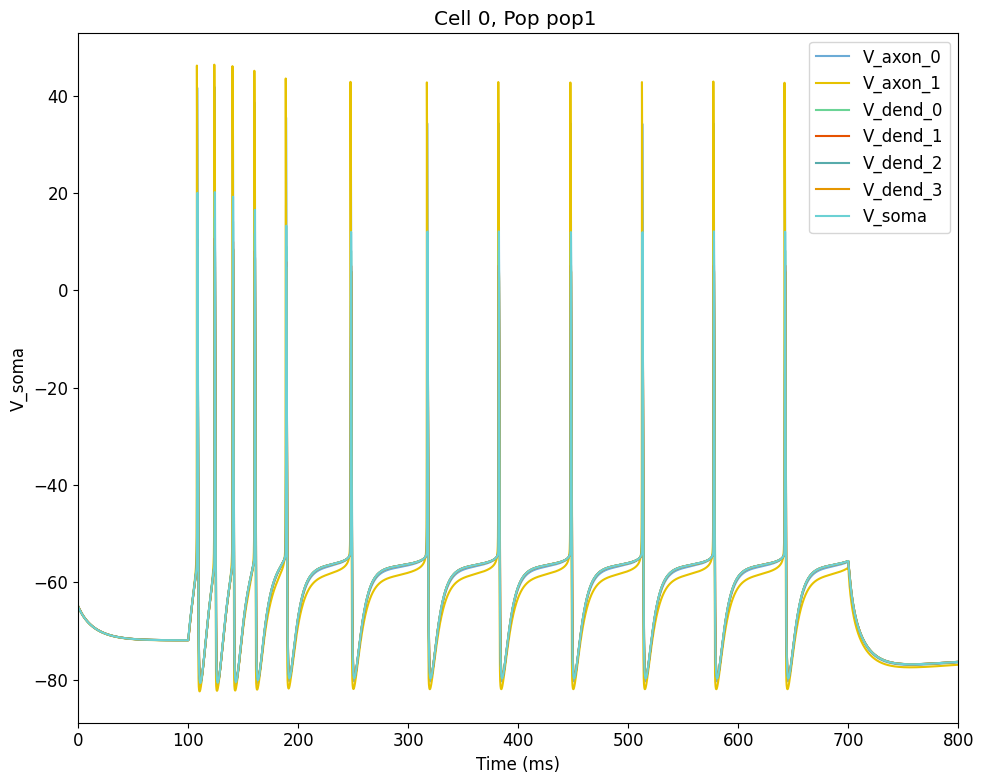

Plotting connectivity matrix...


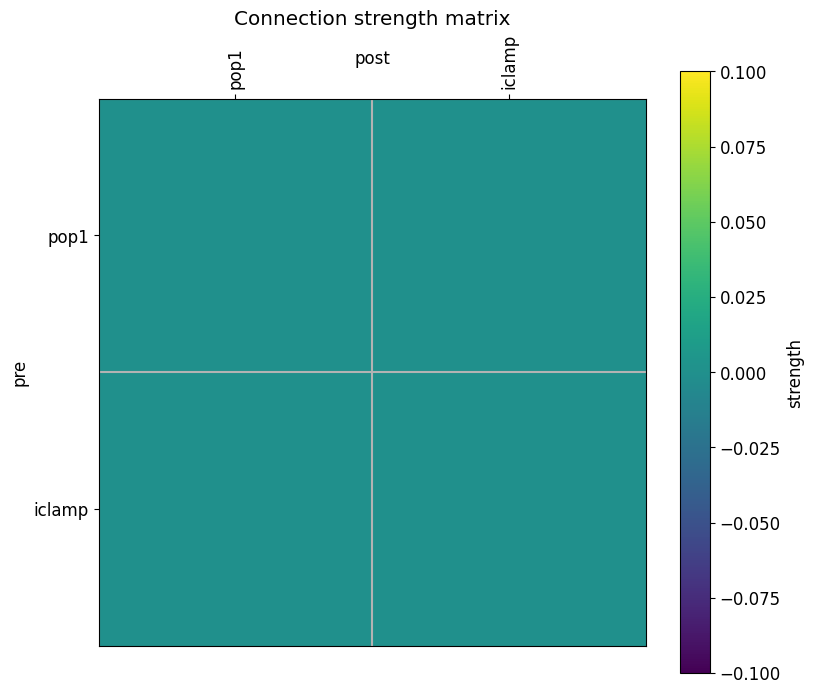

  Done; plotting time = 0.47 s

Total time = 10.18 s

Gathering data...
  Done; gather time = 0.02 s.

Analyzing...
  Cells: 1
  Connections: 0 (0.00 per cell)
  Spikes: 12 (15.00 Hz)
  Simulated time: 0.8 s; 1 workers
  Run time: 9.11 s
Saving output as step_00_data.json ... 
Finished saving!
  Done; saving time = 0.53 s.


In [96]:
import numpy as np

# current_amps = np.loadtxt('current_amps.dat')
# current_amps = np.array([-0.015137, 0.0494352, 0.0535548, 0.0576744])
current_amps = np.array([0.0576744])

# print("Loaded current amps:", current_amps)

for i, amp in enumerate(current_amps):
    print(f'Running step {i} | amp = {amp} nA')
    run_step_netpyne(amp, simLabel=f'step_{i:02d}')


In [86]:
from netpyne import sim

print("recordLFP cfg:", getattr(sim.cfg, "recordLFP", None))
print("simData keys:", sim.simData.keys())
print("Tem LFP?", "LFP" in sim.simData)
if "LFP" in sim.simData:
    import numpy as np
    print("LFP shape:", np.array(sim.simData["LFP"]).shape)


recordLFP cfg: [[50, 50, 0], [0, 40, 0], [0, 40, 50]]
simData keys: dict_keys(['spkt', 'spkid', 'stims', 'V_soma', 'V_axon_0', 'V_axon_1', 'V_dend_0', 'V_dend_1', 'V_dend_2', 'V_dend_3', 't', 'LFP'])
Tem LFP? True
LFP shape: (32000, 3)


Plotting recorded cell traces ... cell


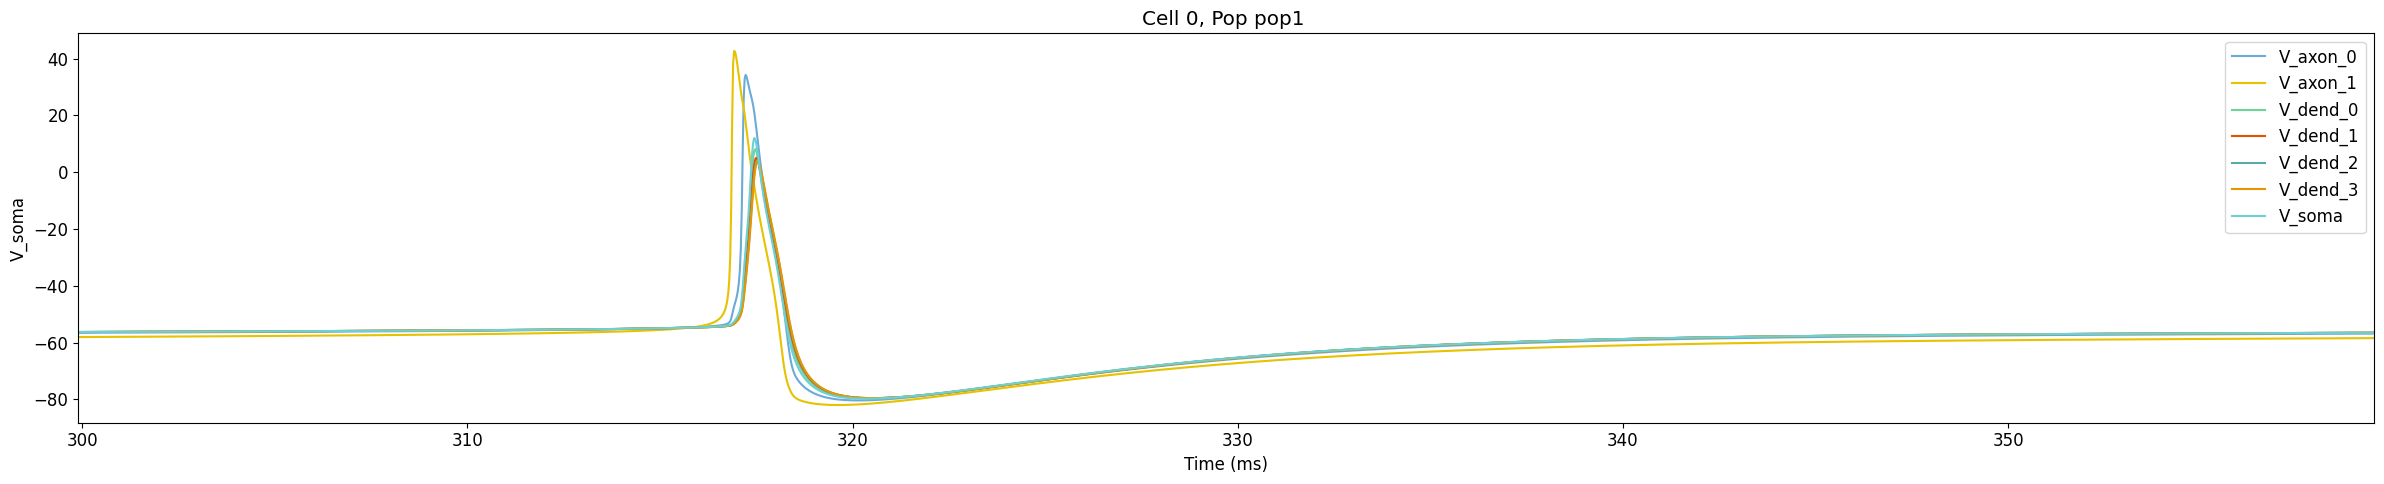

In [38]:
sim.analysis.plotTraces(timeRange=[299.9,359.5],figSize=(24,5), overlay=True);

Plotting 2D representation of network cell locations and connections...


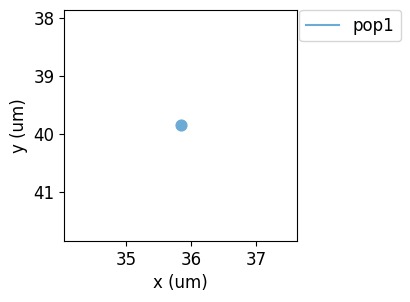

(<Figure size 300x300 with 1 Axes>,
 {'include': ['allCells'],
  'posX': [np.float64(35.83531143706401)],
  'posY': [np.float64(39.84944342173416)],
  'posXpre': [],
  'posXpost': [],
  'posYpre': [],
  'posYpost': []})

In [29]:
sim.analysis.plot2Dnet(figSize=(3,3))

Preparing spike data...
Plotting raster...


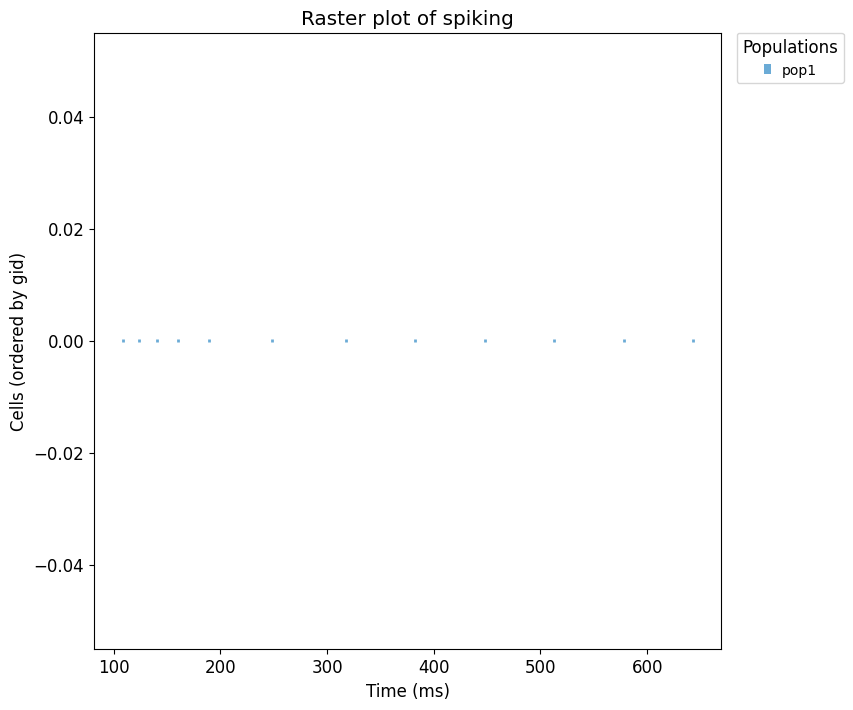

In [30]:
sim.analysis.plotRaster()

In [87]:
sim.analysis.plotShape(
    includePre=['all'], includePost=['all'],
    includeAxon=True,
    showSyns=False,
    showElectrodes=[],      
    cvar='voltage', cvals=None, 
    dist=0.6, elev=95, azim=-90,
    axisLabels=True,
    synStyle='o', synSize=2, synColor='red',
    figSize=(15,15),
    saveFig=True
)

Plotting 3D cell shape ...


(<Figure size 1500x1500 with 2 Axes>, {})

Preparing spike data...
Plotting spike frequency...


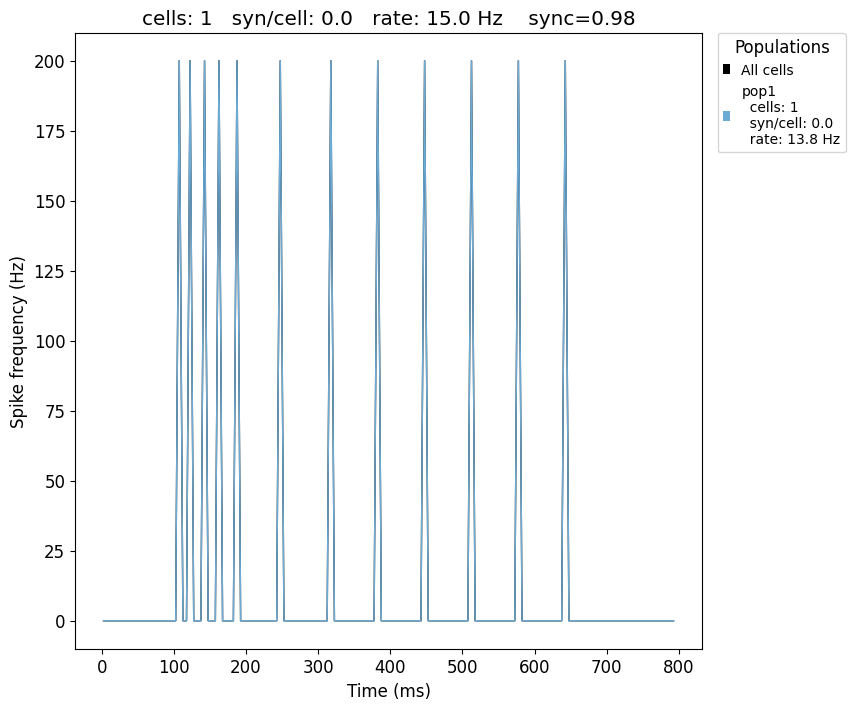

In [50]:
sim.analysis.plotSpikeHist()
# sim.analysis.plotSpikeHist(binSize=20, measure='count')
# plotSpikeHist(binSize=20, measure='count');
# netpyne.analysis.plotSpikeHist(include=['eachPop', 'allCells'], timeRange=None, binSize=5, 
# graphType='line', measure='rate', norm=False, smooth=None, filtFreq=None, filtOrder=3, axis=True, 
# popColors=None, figSize=(10, 8), dpi=100, saveData=None, saveFig=None, showFig=True, **kwargs)[source]

In [ ]:
# import pathlib

# pth = pathlib.Path("/opt/anaconda3/envs/neuron8/lib/python3.10/site-packages/netpyne/plotting/plotShape.py")
# txt = pth.read_text()

# # substituição mais comum (a que aparece no seu traceback)
# old = "cb = plt.colorbar(sm, fraction=0.15, shrink=0.5, pad=0.05, aspect=20)"
# new = "cb = plt.colorbar(sm, ax=plt.gca(), fraction=0.15, shrink=0.5, pad=0.05, aspect=20)"

# if old in txt:
#     pth.write_text(txt.replace(old, new))
#     print("✅ Patch aplicado em:", pth)
# else:
#     # fallback: procura qualquer plt.colorbar(sm, ...) e injeta ax=plt.gca()
#     import re
#     patched = re.sub(r"plt\.colorbar\(\s*sm\s*,", "plt.colorbar(sm, ax=plt.gca(),", txt, count=1)
#     if patched != txt:
#         pth.write_text(patched)
#         print("✅ Patch aplicado (fallback) em:", pth)
#     else:
#         print("❌ Não encontrei a chamada plt.colorbar(sm, ...) nesse arquivo. Procure manualmente por 'colorbar('")


✅ Patch aplicado em: /opt/anaconda3/envs/neuron8/lib/python3.10/site-packages/netpyne/plotting/plotShape.py


Preparing LFP data...
Plotting LFP time series...
Preparing LFP data...
Preparing PSD data...
Plotting LFP power spectral density (PSD)...
Preparing LFP data...
Preparing spectrogram data...
Plotting LFP spectrogram...
Plotting LFP electrode locations...
Plotting 3D cell shape ...


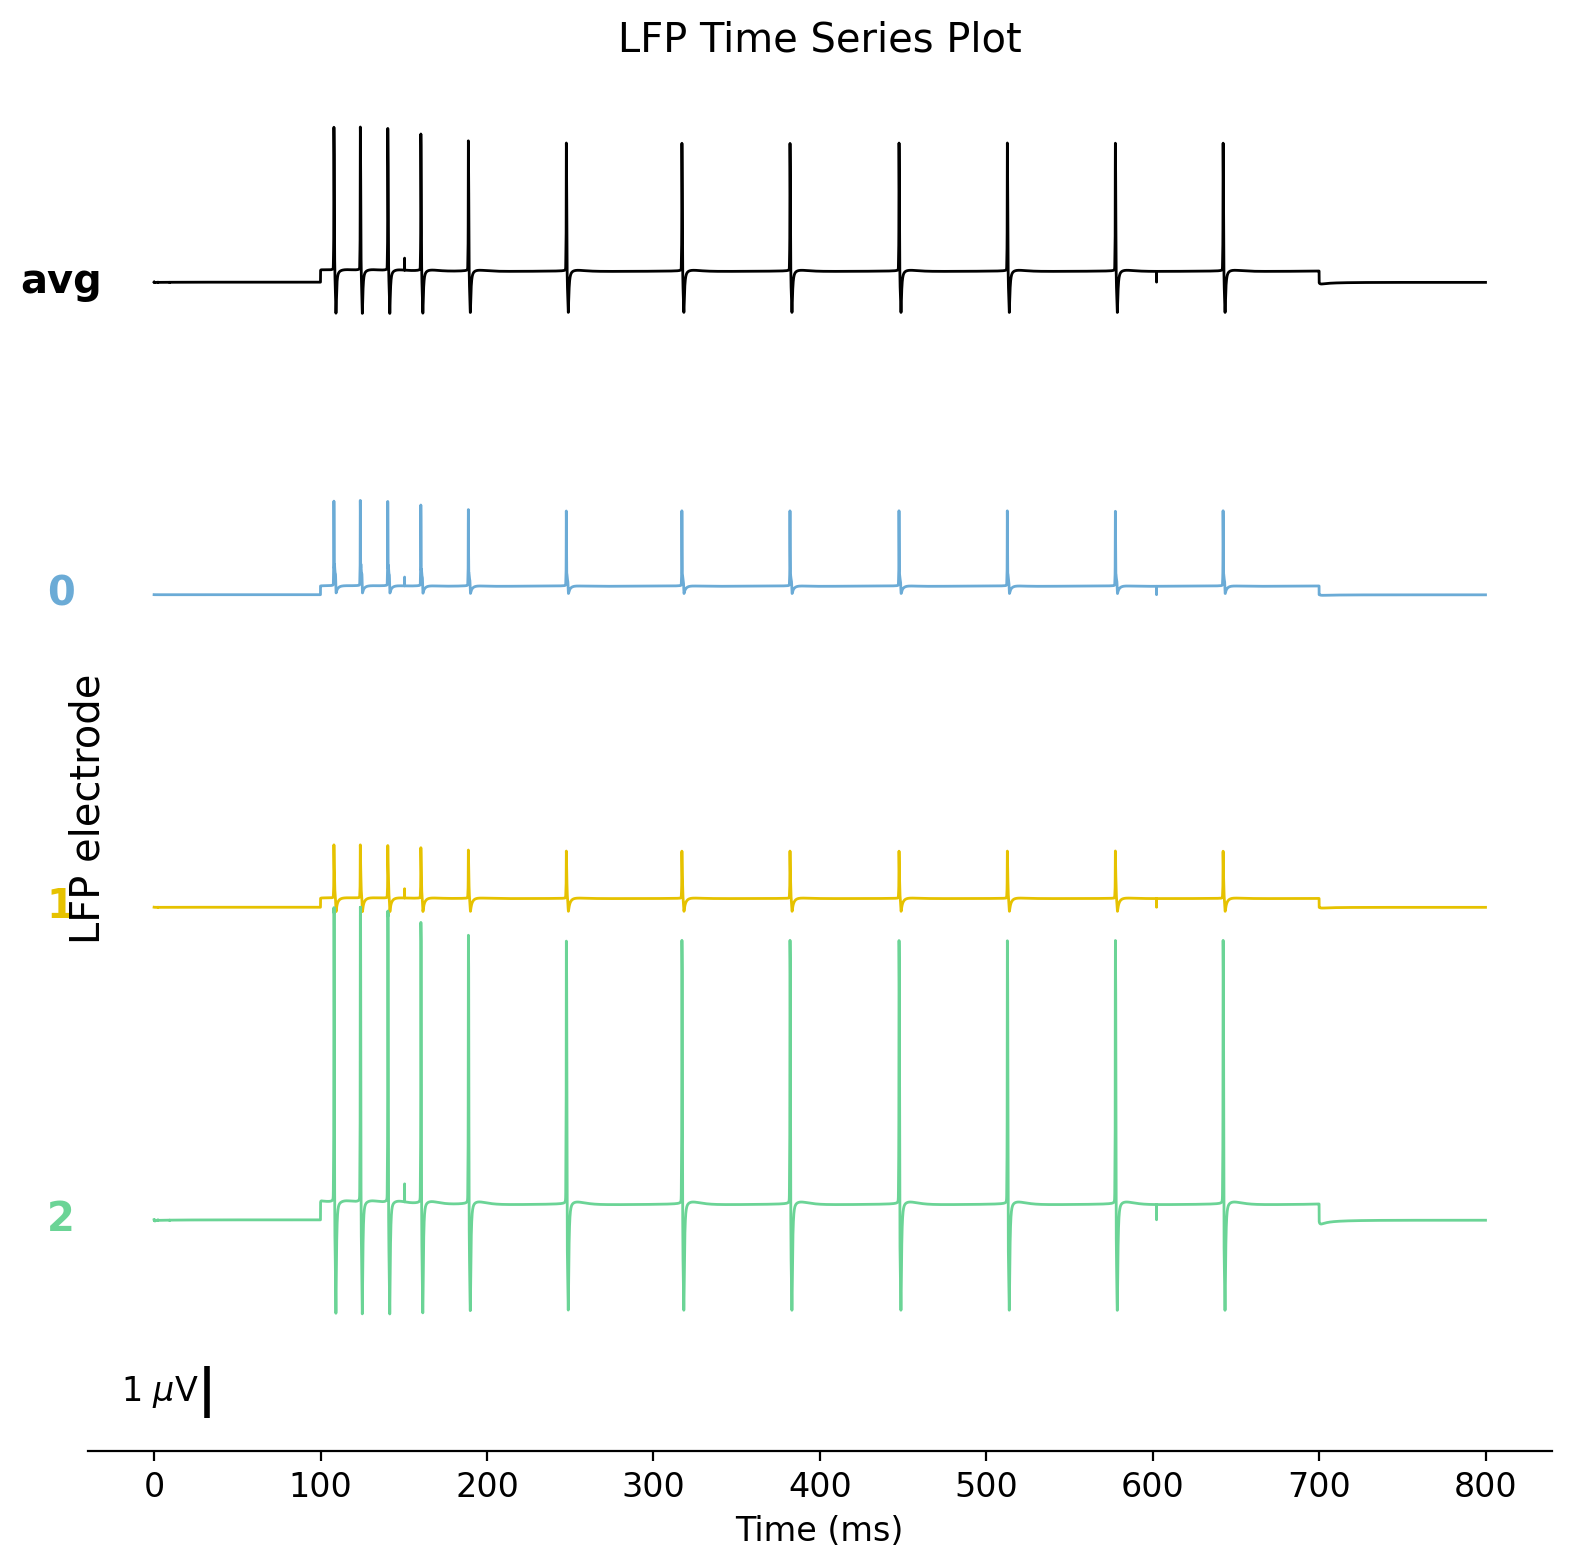

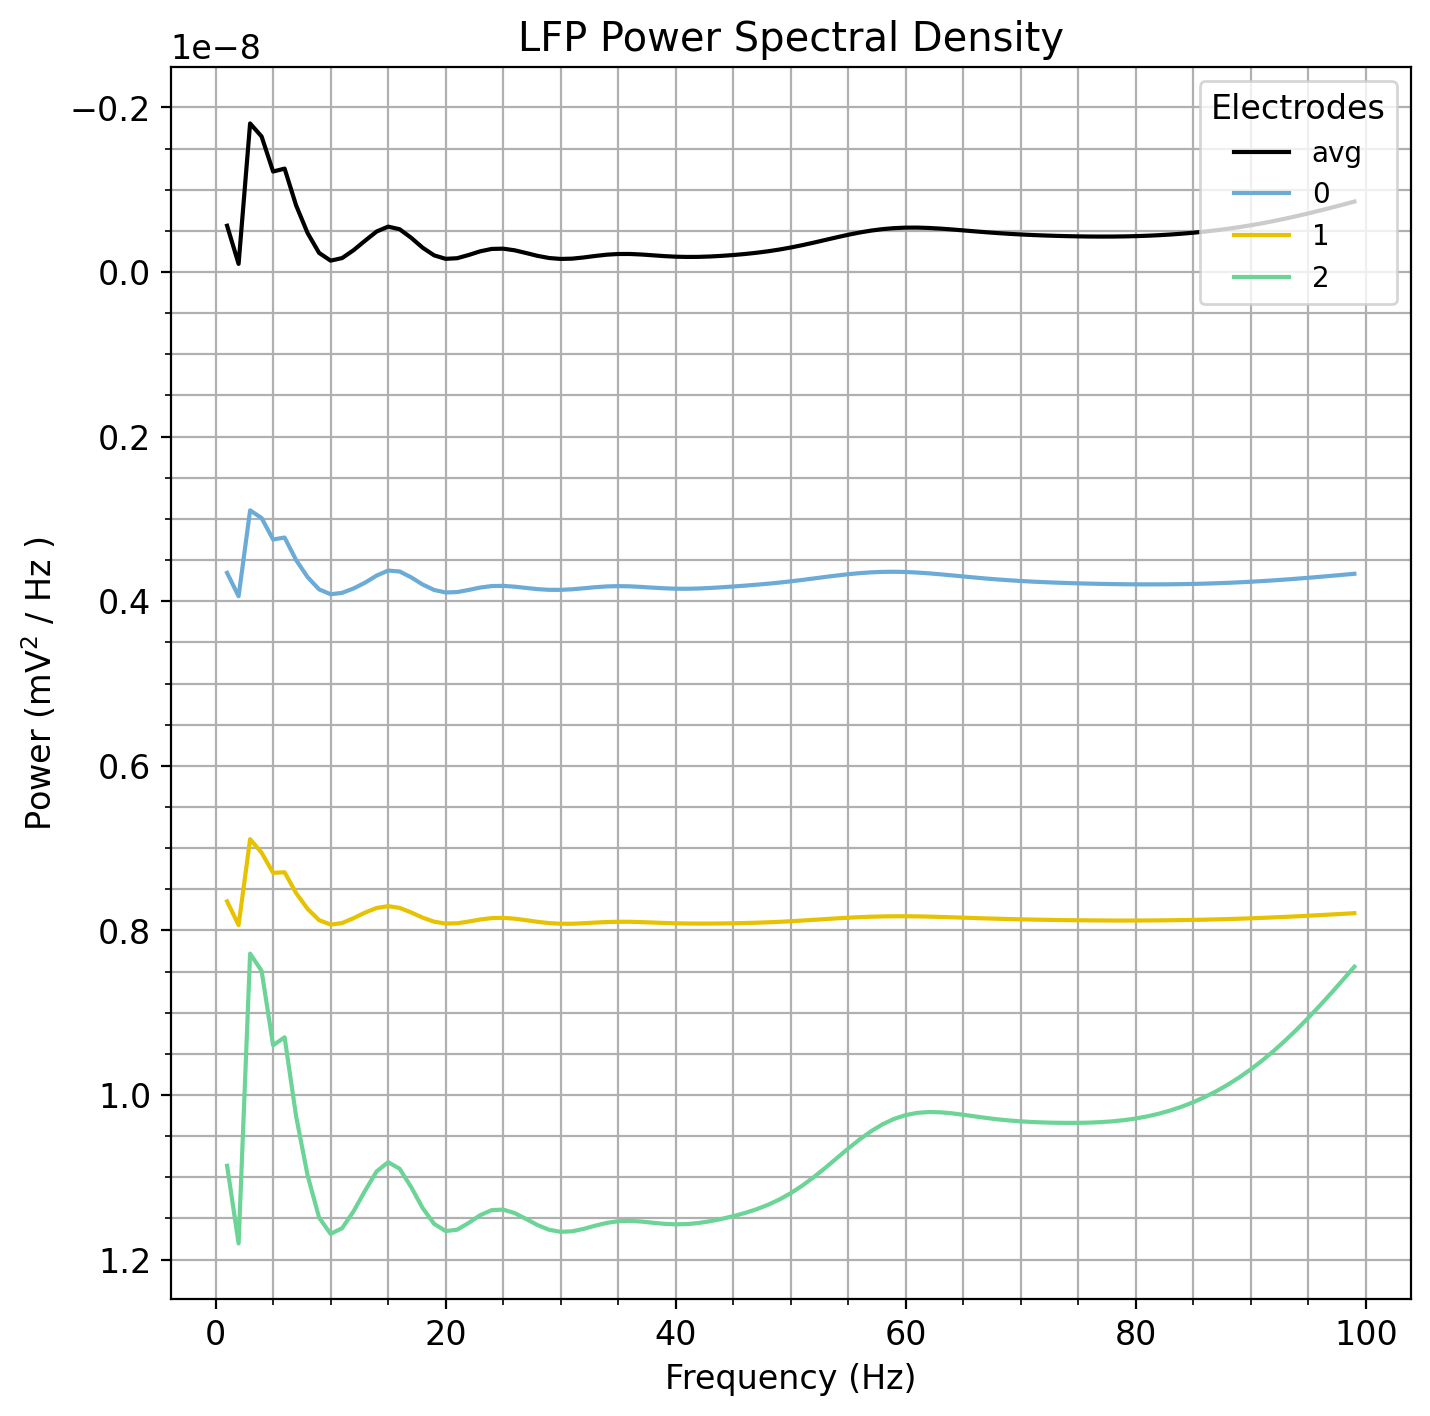

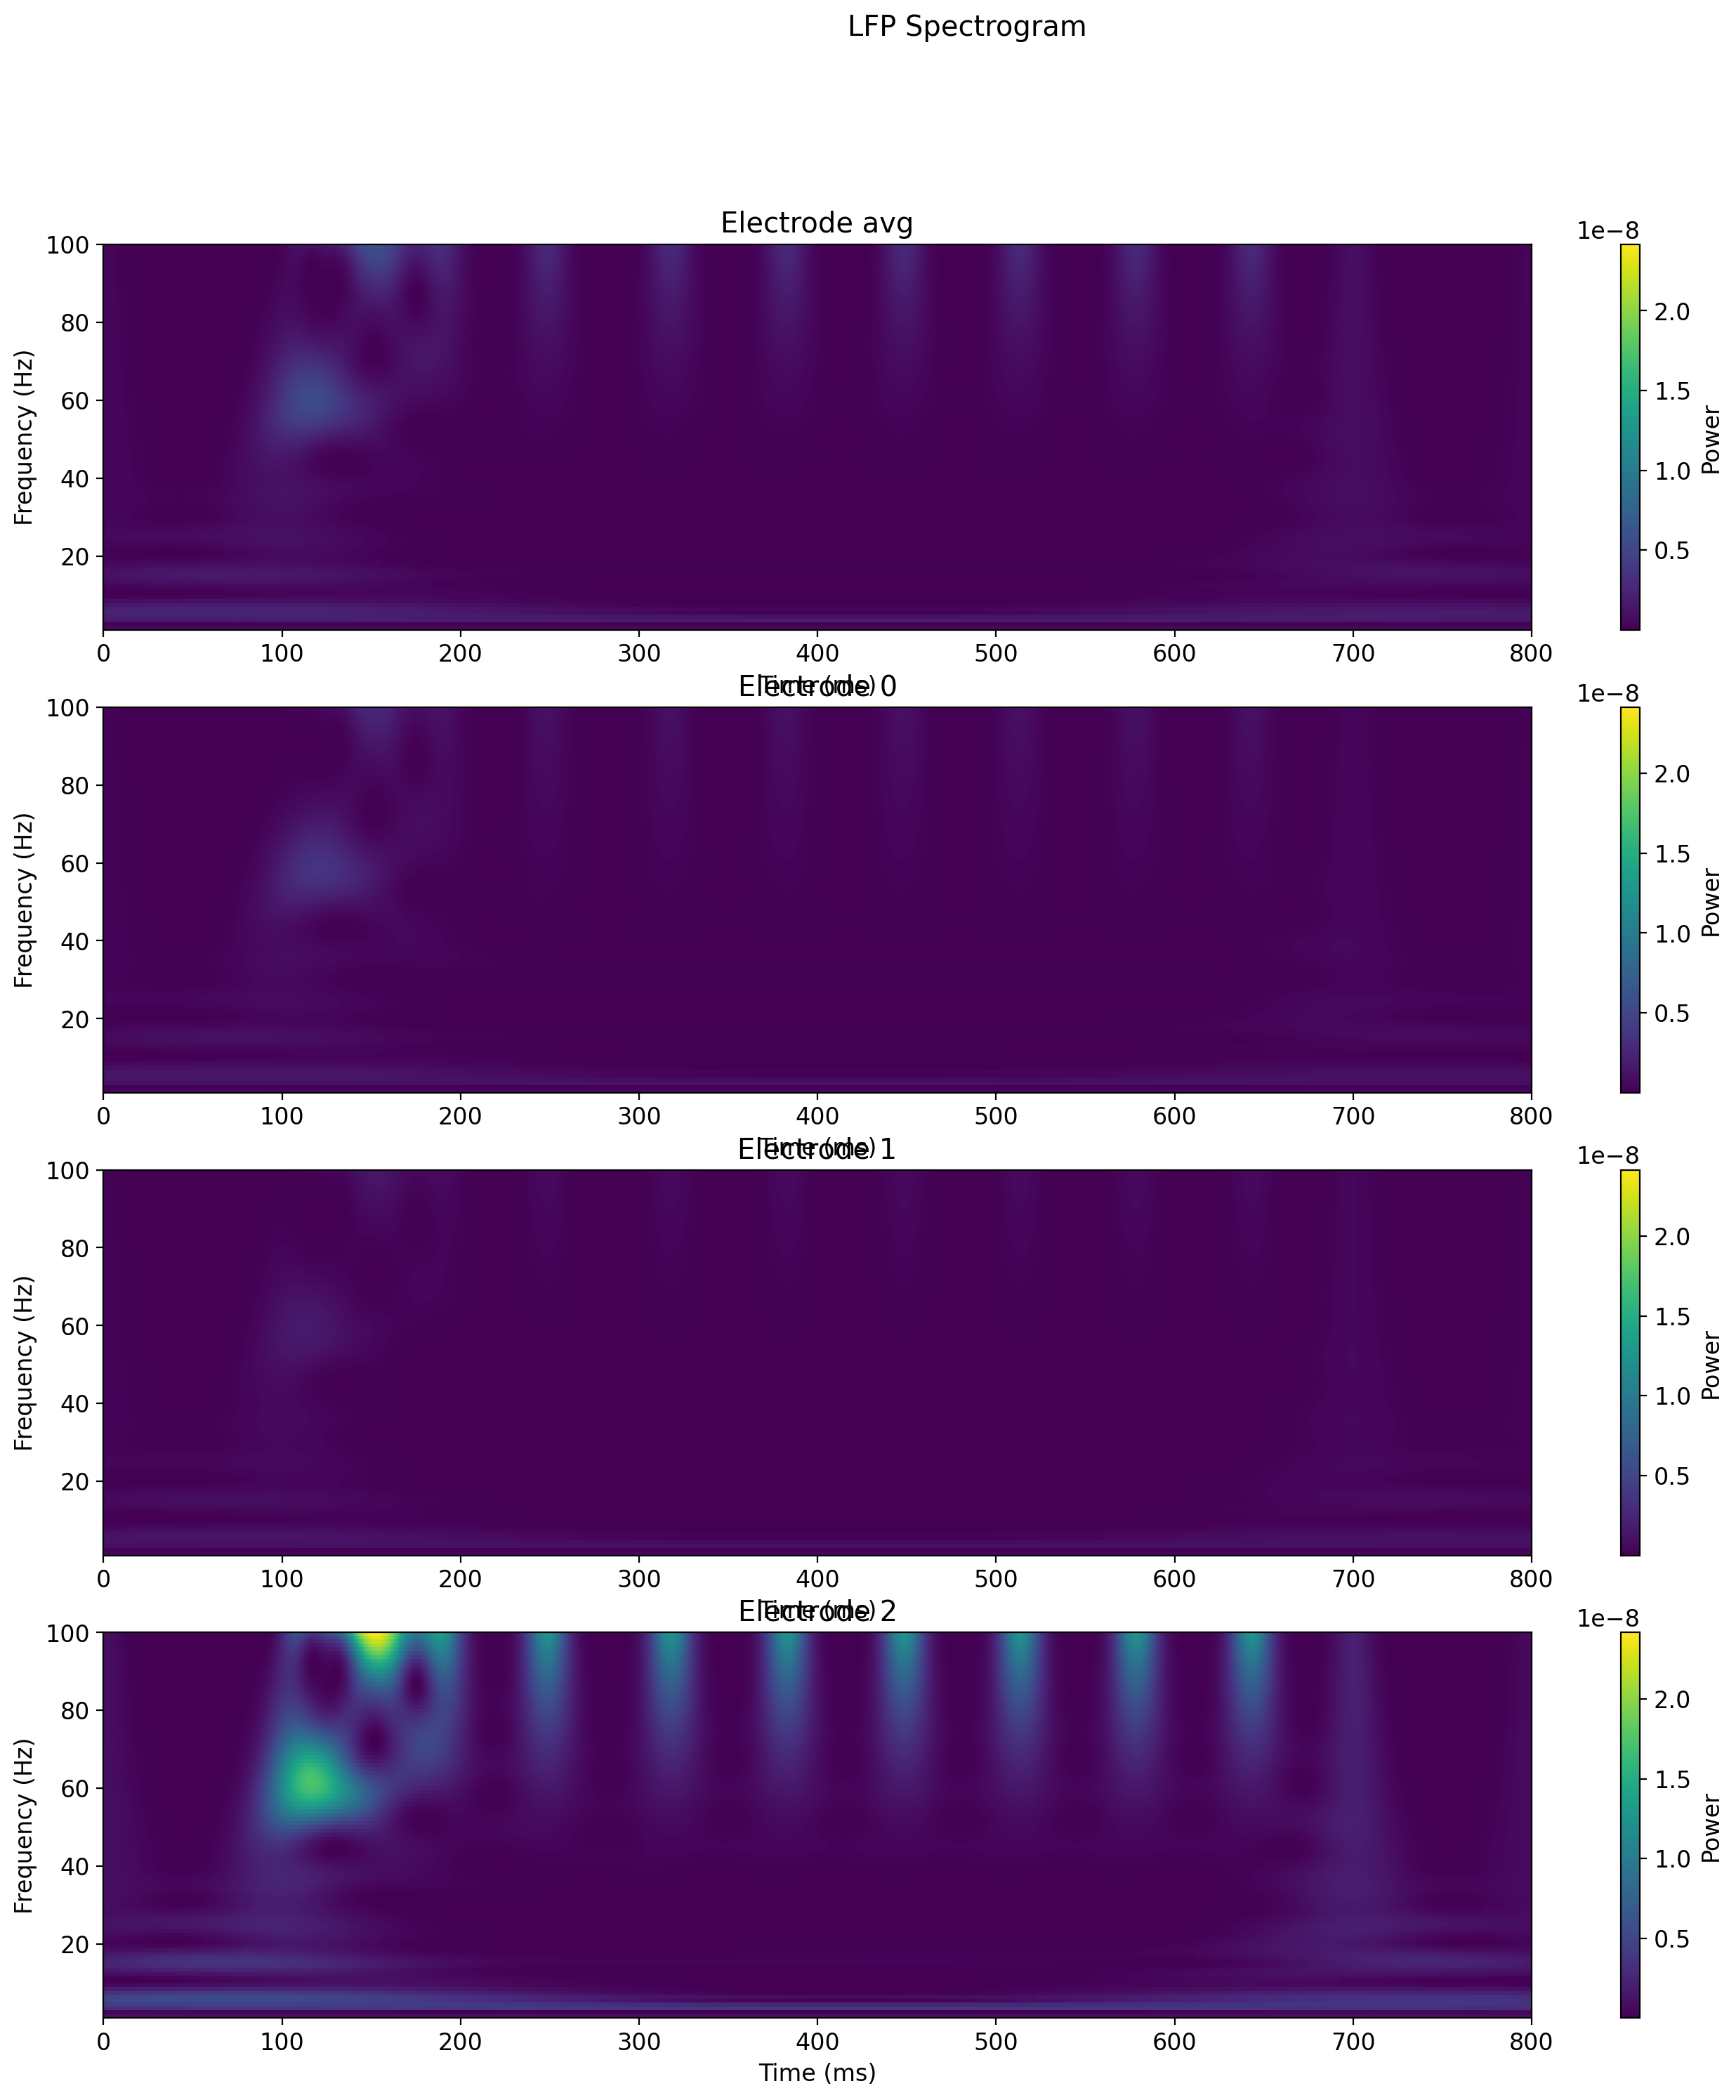

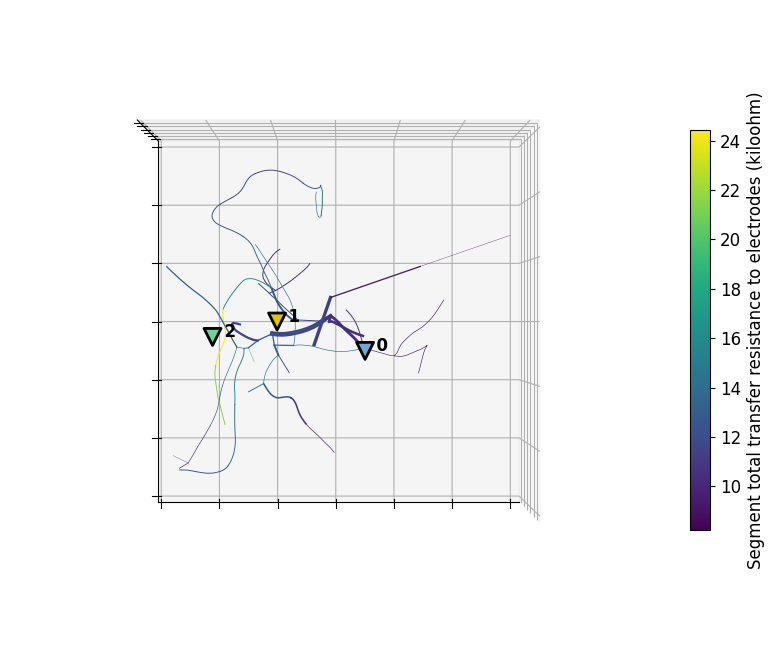

In [97]:
sim.analysis.plotLFP();

In [99]:
from netpyne import sim

cells = sim.net.cells
print("Num cells:", len(cells))

if len(cells) > 0:
    print("secs:", cells[0].secs.keys())


Num cells: 1
secs: dict_keys(['soma_0', 'dend_0', 'dend_1', 'dend_2', 'dend_3', 'dend_4', 'dend_5', 'dend_6', 'dend_7', 'dend_8', 'dend_9', 'dend_10', 'dend_11', 'dend_12', 'dend_13', 'dend_14', 'dend_15', 'dend_16', 'dend_17', 'dend_18', 'dend_19', 'dend_20', 'dend_21', 'dend_22', 'dend_23', 'dend_24', 'dend_25', 'dend_26', 'dend_27', 'dend_28', 'dend_29', 'dend_30', 'dend_31', 'dend_32', 'dend_33', 'dend_34', 'dend_35', 'dend_36', 'axon_0', 'axon_1'])


We already have:
current_amps.dat ✔️
several files step_00.json, step_01.json, … ✔️
a recorded V_sum trace ✔️

Now let's:
1️⃣ Detect spikes from the membrane potential
2️⃣ Calculate firing rate at each current step
3️⃣ Construct the F-I curve
4️⃣ Generate a figure ready for validation in the paper

Spike Detection Function (same as standard NEURON)

In the original run.py, spikes are counted when:

V crosses a threshold (typically 0 mV or −20 mV)
within the stimulus interval (100–700 ms)

In [100]:
import json
import numpy as np
import os

def compute_firing_rate(step_idx, thresh=-20.0):

    base = '/Users/sabrinadefigueiredosouto/Documents/241165/cells/L1_NGC-DA_bNAC219_2'
    fname = os.path.join(base, f'step_{step_idx:02d}_data.json')

    with open(fname) as f:
        data = json.load(f)

    t = np.array(data['simData']['t'])
    # v = np.array(list(data['simData']['V_soma'].values())[0])

    # automatically find the soma voltage trace
    Vtrace = None
    for key, val in data['simData'].items():
        if key.lower().startswith('v'):   # it takes V_soma, V, v_soma_0, etc.
            if isinstance(val, dict) and len(val) > 0:
                Vtrace = np.array(next(iter(val.values())))
                break
            elif isinstance(val, list):
                Vtrace = np.array(val)
                break

    if Vtrace is None:
        raise RuntimeError("voltage no found in the trace, verify recordTraces in simConfig.")

    v = Vtrace

    

    # stim window (same as in protocol)
    stim_mask = (t > 100) & (t < 700)
    t_stim = t[stim_mask]
    v_stim = v[stim_mask]

    # detect matches in the limiar (spikes)
    crossings = (v_stim[:-1] < thresh) & (v_stim[1:] >= thresh)
    spike_times = t_stim[1:][crossings]

    # stim duration in seconds
    stim_dur = (700 - 100) / 1000.0  # 0.6 s

    firing_rate = len(spike_times) / stim_dur  # Hz

    return firing_rate, spike_times


In [101]:
import glob
import matplotlib.pyplot as plt

files = sorted(glob.glob("step_*.json"))
# current_amps = np.loadtxt('current_amps.dat')
current_amps = np.array([0.0576744])

rates = []
all_spikes = []

for i, amp in enumerate(current_amps):
    fr, spikes = compute_firing_rate(i)
    rates.append(fr)
    all_spikes.append(spikes)
    print(f'I = {amp:.4f} nA → F = {fr:.2f} Hz ({len(spikes)} spikes)')


I = 0.0577 nA → F = 20.00 Hz (12 spikes)


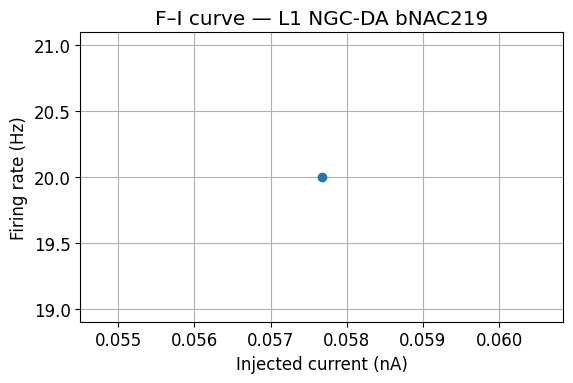

In [102]:
plt.figure(figsize=(6,4))
plt.plot(current_amps, rates, 'o-', lw=2)

plt.xlabel('Injected current (nA)')
plt.ylabel('Firing rate (Hz)')
plt.title('F–I curve — L1 NGC-DA bNAC219')

plt.grid(True)
plt.tight_layout()
plt.show()


In [51]:
from neuron import h
from netpyne import specs
netParams = specs.NetParams()
print(list(netParams.cellParams))

[]
